In [ ]:
###### import statements #######
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder

In [ ]:
###### Read the data ########

user_health_data = pd.read_csv('kidney_disease.csv')
user_health_data = user_health_data.sample(frac=1)
user_health_data.reset_index(drop=True, inplace=True)

In [ ]:
##### SANITY CHECK ######

# Question - Data Sufficiency
# Question - Type of Problem
# Question - Identify target column
# Question - Target distribution. Identify presence of class imbalance
# Question - Do we have columns that can help us predict target

data_shape = user_health_data.shape
data_columns = user_health_data.columns

target_distribution = user_health_data['classification'].value_counts()

In [ ]:
target_distribution

ckd       248
notckd    150
ckd\t       2
Name: classification, dtype: int64

In [ ]:
data_shape, data_columns, target_distribution

((400, 26),
 Index(['id', 'age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr',
        'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad',
        'appet', 'pe', 'ane', 'classification'],
       dtype='object'),
 ckd       248
 notckd    150
 ckd\t       2
 Name: classification, dtype: int64)

In [ ]:
########## Exploratory Data Analysis #######

user_health_data.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,262,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,...,43,7200,5.4,no,no,no,good,no,no,notckd
1,276,20.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,...,41,4500,5.5,no,no,no,good,no,no,notckd
2,265,50.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,...,48,10500,5,no,no,no,good,no,no,notckd
3,170,66.0,70.0,1.015,2.0,5.0,NaN,normal,notpresent,notpresent,...,33,9600,4.4,yes,yes,no,good,no,no,ckd
4,344,64.0,60.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,...,42,8100,4.7,no,no,no,good,no,no,notckd


In [ ]:
#### Insight - There seems to be an issue with pcv, wc and rc columns

user_health_data.dtypes

id                  int64
age               float64
bp                float64
sg                float64
al                float64
su                float64
rbc                object
pc                 object
pcc                object
ba                 object
bgr               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
pcv                object
wc                 object
rc                 object
htn                object
dm                 object
cad                object
appet              object
pe                 object
ane                object
classification     object
dtype: object

In [ ]:
#### Lets check for missing values
#### Insight - Data has missing values

user_health_data.isnull().sum()
(user_health_data.isnull().sum()/user_health_data.shape[0])*100

id                 0.00
age                2.25
bp                 3.00
sg                11.75
al                11.50
su                12.25
rbc               38.00
pc                16.25
pcc                1.00
ba                 1.00
bgr               11.00
bu                 4.75
sc                 4.25
sod               21.75
pot               22.00
hemo              13.00
pcv               17.50
wc                26.25
rc                32.50
htn                0.50
dm                 0.50
cad                0.50
appet              0.25
pe                 0.25
ane                0.25
classification     0.00
dtype: float64

IndexError: ignored

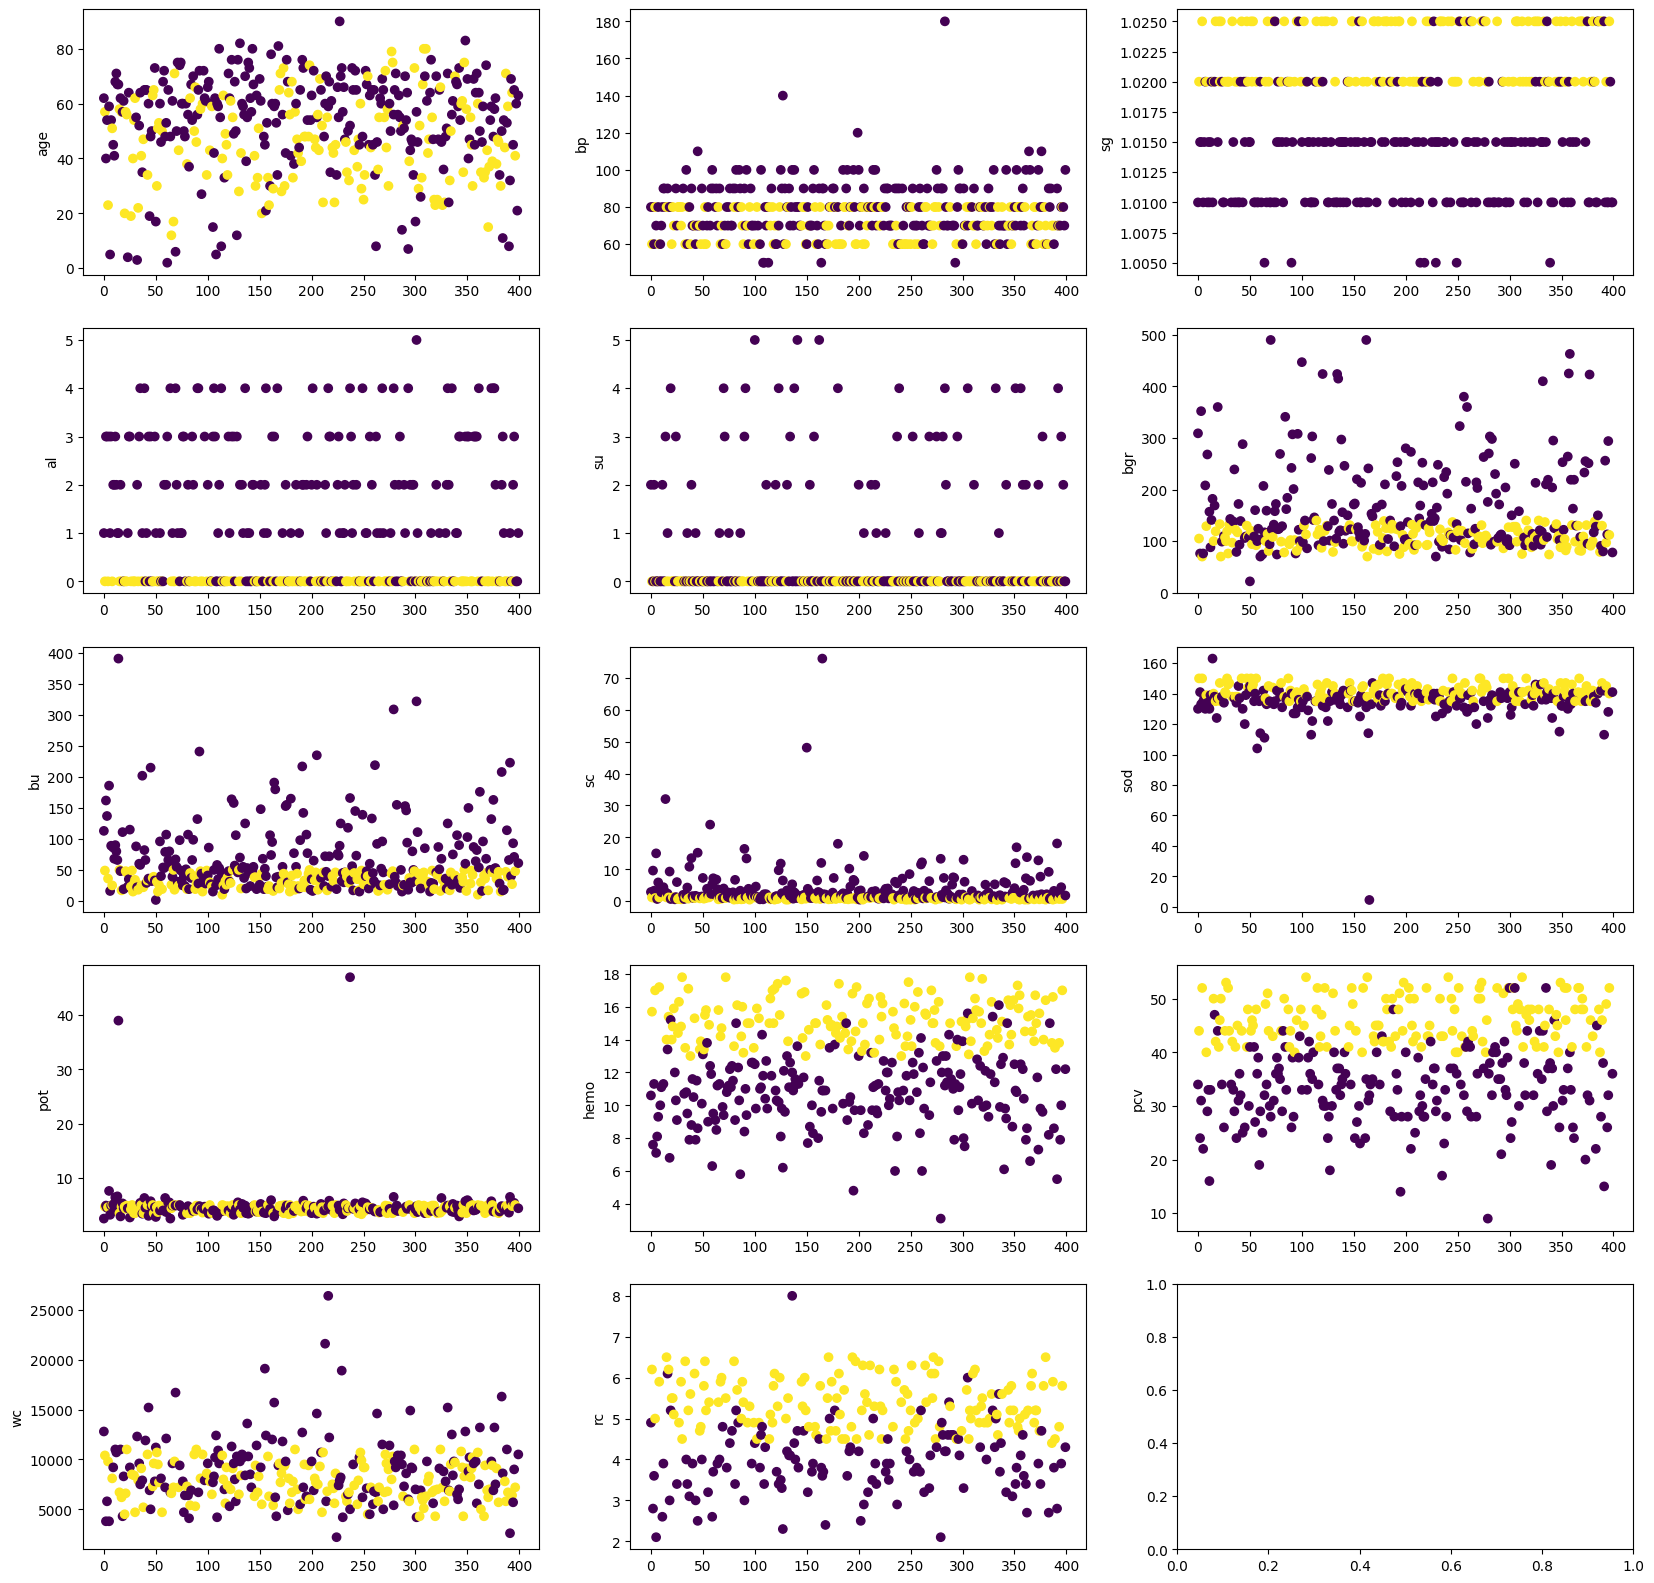

In [ ]:
### check for outliers

#### Visualizing numeric columns ######

numeric_cols = user_health_data.select_dtypes(include = np.number) ### selects numeric columns

column_names = list(numeric_cols.columns)

col_index = 0

plot_rows = 5
plot_cols = 3

fig, ax = plt.subplots(nrows = plot_rows,ncols=plot_cols,figsize = (20,20))

for row_count in range(plot_rows):
    for col_count in range(plot_cols):
        ax[row_count][col_count].scatter(y = numeric_cols[column_names[col_index]],x=numeric_cols.index, c= [0 if x == 'ckd' else 1 for x in user_health_data['classification']])
        ax[row_count][col_count].set_ylabel(column_names[col_index])
        col_index = col_index + 1

#### INSIGHTS #####
# Id column can be dropped
# There are persons with BP and hemo=0.. consider them as missing values and impute them
# SG, AL, SU are behaving more like a categorical column as it takes only specific values
# There is one customer with sodium level 0

In [ ]:
##### Lets analyze the categorical columns ######
#### INSIGHTS ####
## dm, cad and classification columns needs preprocessing

categorical_data = user_health_data.select_dtypes(include = 'object')

categorical_colnames = list(categorical_data.columns)

for col_name in categorical_colnames:
  print ('*****************')
  print (col_name)
  print (categorical_data[col_name].value_counts())


*****************
rbc
normal      201
abnormal     47
Name: rbc, dtype: int64
*****************
pc
normal      259
abnormal     76
Name: pc, dtype: int64
*****************
pcc
notpresent    354
present        42
Name: pcc, dtype: int64
*****************
ba
notpresent    374
present        22
Name: ba, dtype: int64
*****************
pcv
41      21
52      21
44      19
48      19
40      16
43      14
42      13
45      13
50      12
28      12
36      12
33      12
32      12
37      11
34      11
46       9
29       9
30       9
35       9
31       8
39       7
24       7
26       6
38       5
49       4
53       4
54       4
47       4
51       4
25       3
27       3
22       3
23       2
19       2
15       1
17       1
16       1
21       1
\t43     1
\t?      1
18       1
9        1
14       1
20       1
Name: pcv, dtype: int64
*****************
wc
9800     11
6700     10
7200      9
9600      9
9200      9
         ..
5900      1
5200      1
16300     1
\t?       1
12100     1
N

<Axes: xlabel='classification', ylabel='pot'>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


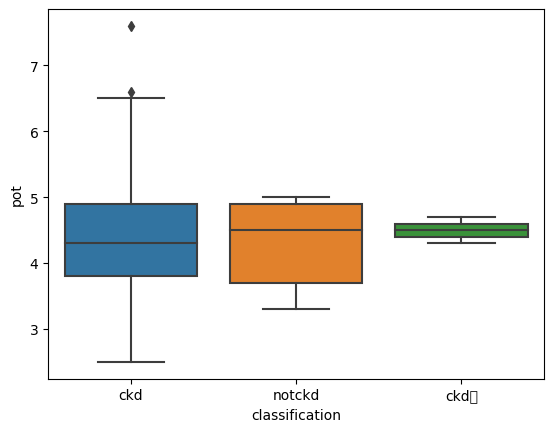

In [ ]:
##### Lets analyze the relationship between features and targets #####

sns.boxplot(x=user_health_data.loc[user_health_data['pot']<30, 'classification'], y= user_health_data.loc[user_health_data['pot']<30, 'pot'])

In [ ]:
user_health_data.corr()

<ipython-input-86-9af748143fbf>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  user_health_data.corr()


,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc
age,1.000000,0.138145,-0.172944,0.085918,0.219392,0.255673,0.191109,0.132121,-0.100263,0.057955,-0.188472,-0.239868,0.118174,-0.268985
bp,0.138145,1.000000,-0.206473,0.122271,0.218112,0.164690,0.184318,0.145114,-0.114973,0.072974,-0.306575,-0.322844,0.030305,-0.259013
sg,-0.172944,-0.206473,1.000000,-0.395387,-0.282176,-0.290232,-0.327175,-0.290754,0.417341,-0.067002,0.578449,0.583964,-0.179648,0.561669
al,0.085918,0.122271,-0.395387,1.000000,0.269305,0.300809,0.352689,0.164507,-0.257445,0.126066,-0.498591,-0.518036,0.236637,-0.491917
su,0.219392,0.218112,-0.282176,0.269305,1.000000,0.697623,0.166399,0.222662,-0.131776,0.219450,-0.218190,-0.239189,0.184893,-0.237448
bgr,0.255673,0.164690,-0.290232,0.300809,0.697623,1.000000,0.156821,0.116777,-0.212694,0.069504,-0.303393,-0.298379,0.134332,-0.292254
bu,0.191109,0.184318,-0.327175,0.352689,0.166399,0.156821,1.000000,0.581731,-0.322056,0.356931,-0.605845,-0.604012,0.051457,-0.575671
sc,0.132121,0.145114,-0.290754,0.164507,0.222662,0.116777,0.581731,1.000000,-0.689042,0.326433,-0.401272,-0.402914,-0.004374,-0.400991
sod,-0.100263,-0.114973,0.417341,-0.257445,-0.131776,-0.212694,-0.322056,-0.689042,1.000000,0.097887,0.363104,0.376914,0.007277,0.344873
pot,0.057955,0.072974,-0.067002,0.126066,0.219450,0.069504,0.356931,0.326433,0.097887,1.000000,-0.129260,-0.163182,-0.105576,-0.158309


In [ ]:
###### PREPROCESSING ######

##### Resolve the issues that are converting numeric cols to object types
##### When there are string values in any one of the entry for the columns
##### Identify the non numeric values in the column --> Treatment

In [ ]:
def identify_non_numeric(series_):
  non_numeric_elem = []
  for elem in series_:
    try:
      float(elem)
    except:
      non_numeric_elem.append(elem)
  return non_numeric_elem

In [ ]:
cols_to_analyze = ['pcv', 'wc', 'rc']

for col in cols_to_analyze:
  non_numeric_elems = identify_non_numeric(user_health_data[col])
  print ('***********')
  print (col)
  print (non_numeric_elems)


for col in cols_to_analyze:
  user_health_data[col] = pd.to_numeric(user_health_data[col], errors='coerce')

***********
pcv
['\t?']
***********
wc
['\t?']
***********
rc
['\t?']


In [ ]:
user_health_data.dtypes

id                  int64
age               float64
bp                float64
sg                float64
al                float64
su                float64
rbc                object
pc                 object
pcc                object
ba                 object
bgr               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
pcv               float64
wc                float64
rc                float64
htn                object
dm                 object
cad                object
appet              object
pe                 object
ane                object
classification     object
dtype: object

In [ ]:
###### Processing the categorical columns #######

user_health_data['dm'].value_counts()

user_health_data.loc[user_health_data['dm'] == '\tno', 'dm'] = 'no'
user_health_data.loc[user_health_data['dm'] == '\tyes', 'dm'] = 'yes'
user_health_data.loc[user_health_data['dm'] == ' yes', 'dm'] = 'yes'

In [ ]:
user_health_data['cad'].value_counts()

user_health_data.loc[user_health_data['cad'] == '\tno', 'cad'] = 'no'

In [ ]:
user_health_data['classification'].value_counts()

user_health_data.loc[user_health_data['classification'] == 'ckd\t', 'classification'] = 'ckd'

In [ ]:
######### Preprocessing - 2 #############

user_health_data.drop(['id'], axis=1, inplace=True)

In [ ]:
user_health_data.loc[user_health_data['bp']<25, 'bp'] = np.nan

user_health_data.loc[user_health_data['hemo']<1, 'hemo'] = np.nan

In [ ]:
######### Missing value imputations ########

user_health_data.isnull().sum()
(user_health_data.isnull().sum()/user_health_data.shape[0])*100

age                2.25
bp                 3.50
sg                11.75
al                11.50
su                12.25
rbc               38.00
pc                16.25
pcc                1.00
ba                 1.00
bgr               11.00
bu                 4.75
sc                 4.25
sod               21.75
pot               22.00
hemo              13.50
pcv               17.75
wc                26.50
rc                32.75
htn                0.50
dm                 0.50
cad                0.50
appet              0.25
pe                 0.25
ane                0.25
classification     0.00
dtype: float64

In [ ]:
##### Missing value percentage row wise ######

rowwise_missing = (user_health_data.isnull().sum(axis=1)/user_health_data.shape[1])*100

In [ ]:
rowwise_missing.describe()

count    400.000000
mean      10.160000
std       11.716552
min        0.000000
25%        0.000000
50%        4.000000
75%       16.000000
max       44.000000
dtype: float64

In [ ]:
###### ANALYSIS OF COLUMNS #####
user_health_data['age'].describe()

count    391.000000
mean      51.483376
std       17.169714
min        2.000000
25%       42.000000
50%       55.000000
75%       64.500000
max       90.000000
Name: age, dtype: float64

<ipython-input-20-67a8fcced371>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(user_health_data['age'])


<Axes: xlabel='age', ylabel='Density'>

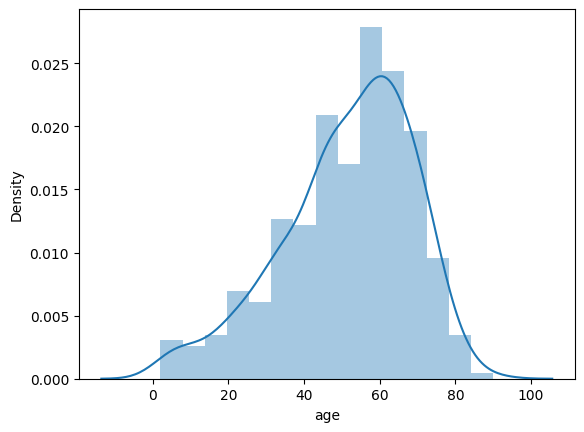

In [ ]:
sns.distplot(user_health_data['age'])

In [ ]:
user_health_data.loc[user_health_data['age'].isnull(), 'age'] = 55

In [ ]:
######### ANALYSIS OF BP COLUMN ######

user_health_data['bp'].describe()

count    386.000000
mean      76.476684
std       13.713989
min       50.000000
25%       70.000000
50%       80.000000
75%       80.000000
max      180.000000
Name: bp, dtype: float64

<ipython-input-23-1bf4e17a6cb6>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(user_health_data['bp'])


<Axes: xlabel='bp', ylabel='Density'>

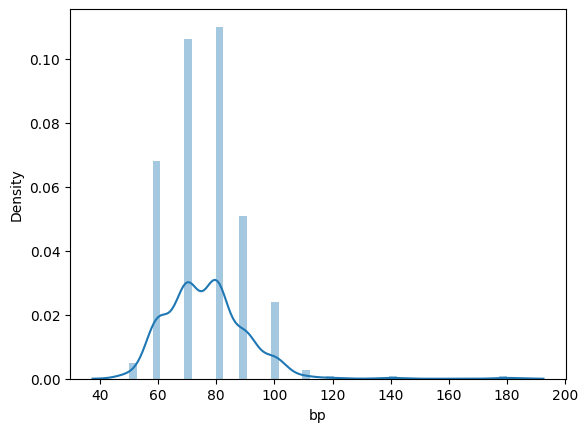

In [ ]:
sns.distplot(user_health_data['bp'])

In [ ]:
user_health_data.loc[user_health_data['bp'].isnull(), 'bp'] = 80

In [ ]:
####### Analysis of SG column #######

user_health_data['sg'].describe()

count    353.000000
mean       1.017408
std        0.005717
min        1.005000
25%        1.010000
50%        1.020000
75%        1.020000
max        1.025000
Name: sg, dtype: float64

In [ ]:
user_health_data['sg'].value_counts()

1.020    106
1.010     84
1.025     81
1.015     75
1.005      7
Name: sg, dtype: int64

In [ ]:
######## ANALYSIS OF HTN Column ########

user_health_data['htn'].value_counts()

user_health_data.loc[user_health_data['htn'].isnull(), 'htn'] = 'no'

In [ ]:
user_health_data['dm'].value_counts()

user_health_data.loc[user_health_data['dm'].isnull(), 'dm'] = 'no'

In [ ]:
user_health_data['cad'].value_counts()

user_health_data['cad'].fillna(value='no', inplace=True)

In [ ]:
user_health_data['appet'].value_counts()
user_health_data['appet'].fillna(value='good', inplace=True)

In [ ]:
user_health_data['pe'].value_counts()
user_health_data['pe'].fillna(value='no', inplace=True)

In [ ]:
user_health_data['ane'].value_counts()
user_health_data['ane'].fillna(value='no', inplace=True)

In [ ]:
######## ANALYSIS OF PCC column ########

user_health_data.loc[user_health_data['pcc'].isnull(),:]

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
67,45.0,60.0,1.02,0.0,0.0,normal,normal,NaN,NaN,114.0,...,43.0,9200.0,5.8,no,no,no,good,no,no,notckd
74,35.0,80.0,1.02,0.0,0.0,normal,normal,NaN,NaN,99.0,...,48.0,5000.0,5.2,no,no,no,good,no,no,notckd
119,28.0,70.0,1.02,0.0,0.0,normal,normal,NaN,NaN,131.0,...,45.0,8600.0,6.5,no,no,no,good,no,no,notckd
125,54.0,70.0,1.02,0.0,0.0,NaN,NaN,NaN,NaN,76.0,...,52.0,8400.0,5.9,no,no,no,good,no,no,notckd


In [ ]:
user_health_data['pcc'].value_counts()

notpresent    354
present        42
Name: pcc, dtype: int64

In [ ]:
user_health_data['pcc'].fillna(value='notpresent', inplace=True)

In [ ]:
user_health_data.loc[user_health_data['ba'].isnull(),:]

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
67,45.0,60.0,1.02,0.0,0.0,normal,normal,notpresent,NaN,114.0,...,43.0,9200.0,5.8,no,no,no,good,no,no,notckd
74,35.0,80.0,1.02,0.0,0.0,normal,normal,notpresent,NaN,99.0,...,48.0,5000.0,5.2,no,no,no,good,no,no,notckd
119,28.0,70.0,1.02,0.0,0.0,normal,normal,notpresent,NaN,131.0,...,45.0,8600.0,6.5,no,no,no,good,no,no,notckd
125,54.0,70.0,1.02,0.0,0.0,NaN,NaN,notpresent,NaN,76.0,...,52.0,8400.0,5.9,no,no,no,good,no,no,notckd


In [ ]:
user_health_data['ba'].value_counts()

notpresent    374
present        22
Name: ba, dtype: int64

In [ ]:
user_health_data['ba'].fillna(value='notpresent', inplace=True)

In [ ]:
##### ANALYSIS OF BLOOD UREA Column ######

user_health_data['bu'].describe()

count    381.000000
mean      57.425722
std       50.503006
min        1.500000
25%       27.000000
50%       42.000000
75%       66.000000
max      391.000000
Name: bu, dtype: float64

<ipython-input-40-3bea5d83b03d>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(user_health_data['bu'])


<Axes: xlabel='bu', ylabel='Density'>

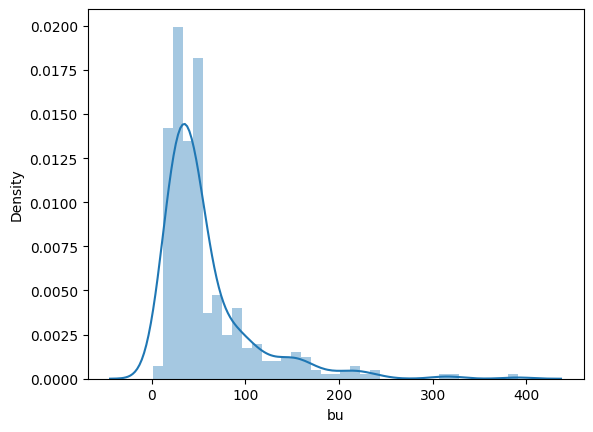

In [ ]:
sns.distplot(user_health_data['bu'])

In [ ]:
user_health_data.loc[user_health_data['bu'].isnull(),:]

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
1,20.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,NaN,...,41.0,4500.0,5.5,no,no,no,good,no,no,notckd
28,61.0,90.0,1.015,0.0,2.0,NaN,normal,notpresent,notpresent,NaN,...,NaN,9800.0,NaN,no,yes,no,poor,no,yes,ckd
107,36.0,80.0,1.010,0.0,0.0,NaN,normal,notpresent,notpresent,103.0,...,36.0,8800.0,NaN,no,no,no,good,no,no,ckd
114,24.0,80.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,125.0,...,43.0,5600.0,4.5,no,no,no,good,no,no,notckd
115,47.0,100.0,1.010,NaN,NaN,normal,NaN,notpresent,notpresent,122.0,...,33.0,10200.0,3.8,no,yes,no,good,no,no,ckd
144,21.0,70.0,1.010,0.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,NaN,NaN,NaN,no,no,no,poor,no,yes,ckd
152,60.0,70.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,NaN,...,43.0,10800.0,5.7,no,no,no,good,no,no,notckd
175,80.0,70.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,NaN,...,48.0,6300.0,6.1,no,no,no,good,no,no,notckd
192,35.0,80.0,1.005,3.0,0.0,abnormal,normal,notpresent,notpresent,NaN,...,28.0,NaN,NaN,no,no,no,good,yes,no,ckd
202,45.0,80.0,1.020,3.0,0.0,normal,abnormal,notpresent,notpresent,425.0,...,NaN,NaN,NaN,no,no,no,poor,no,no,ckd


<Axes: xlabel='pc', ylabel='bu'>

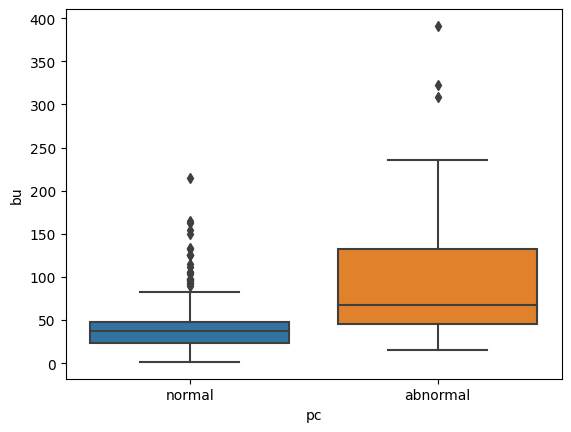

In [ ]:
sns.boxplot(x=user_health_data['pc'], y= user_health_data['bu'])

In [ ]:
user_health_data.loc[user_health_data['pc']=='normal', 'bu'].median()
user_health_data.loc[user_health_data['pc']=='abnormal', 'bu'].median()

67.0

In [ ]:
user_health_data.loc[(user_health_data['bu'].isnull()) & (user_health_data['pc']=='normal'), 'bu'] = 37
user_health_data.loc[(user_health_data['bu'].isnull()) & (user_health_data['pc']=='abnormal'), 'bu'] = 67
user_health_data['bu'].fillna(value=user_health_data['bu'].median(), inplace=True)

<Axes: xlabel='pc', ylabel='sc'>

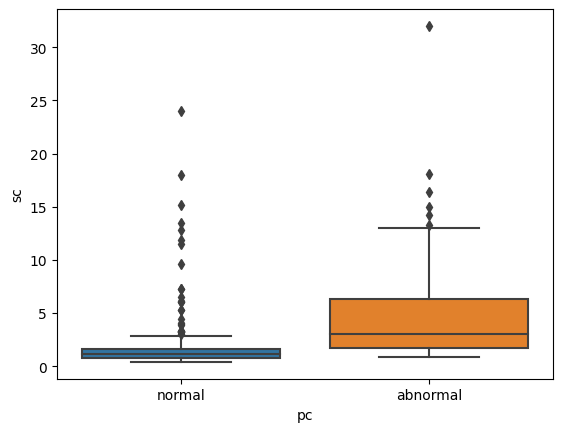

In [ ]:
######### ANALYSIS OF SC COLUMN #########

sns.boxplot(x=user_health_data['pc'], y= user_health_data['sc'])

In [ ]:
print(user_health_data.loc[user_health_data['pc']=='normal', 'sc'].median())
print(user_health_data.loc[user_health_data['pc']=='abnormal', 'sc'].median())

1.1
3.0


In [ ]:
user_health_data.loc[(user_health_data['sc'].isnull()) & (user_health_data['pc']=='normal'), 'sc'] = 1
user_health_data.loc[(user_health_data['sc'].isnull()) & (user_health_data['pc']=='abnormal'), 'sc'] = 3
user_health_data['sc'].fillna(value=user_health_data['sc'].median(), inplace=True)

<ipython-input-142-18d963312b0e>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(user_health_data['sc'])


<Axes: xlabel='sc', ylabel='Density'>

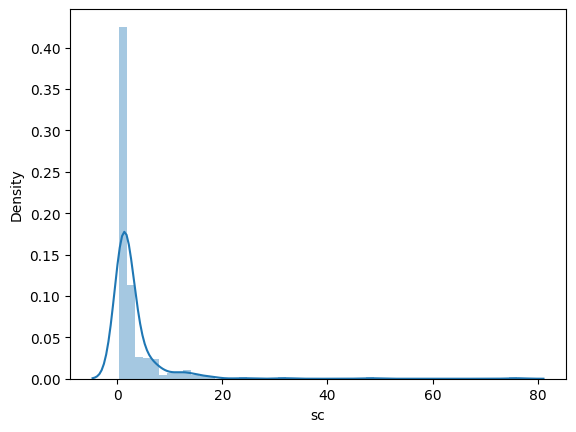

In [ ]:
sns.distplot(user_health_data['sc'])

<ipython-input-44-78956825135c>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(user_health_data['bgr'])


<Axes: xlabel='bgr', ylabel='Density'>

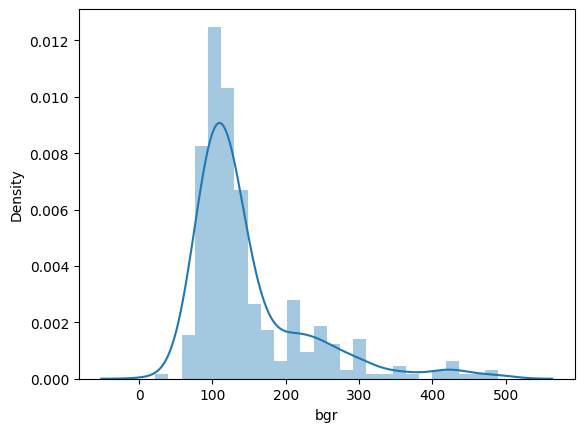

In [ ]:
####### ANALYSIS OF BGR Column #######

sns.distplot(user_health_data['bgr'])

In [ ]:
user_health_data['bgr'].describe()

count    356.000000
mean     148.036517
std       79.281714
min       22.000000
25%       99.000000
50%      121.000000
75%      163.000000
max      490.000000
Name: bgr, dtype: float64

In [ ]:
user_health_data['bgr'].isnull().sum()

44

<Axes: xlabel='dm', ylabel='bgr'>

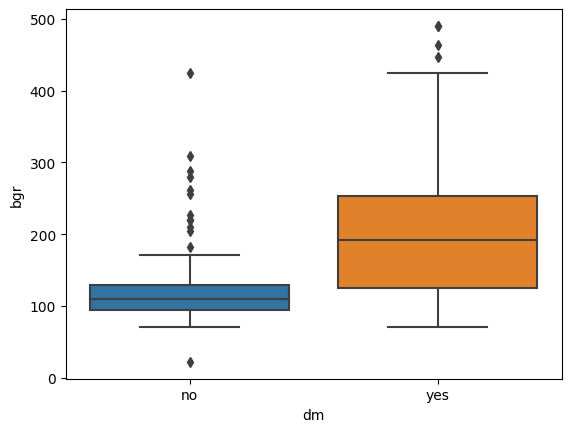

In [ ]:
sns.boxplot(x=user_health_data['dm'], y= user_health_data['bgr'])

In [ ]:
print(user_health_data.loc[user_health_data['dm']=='no', 'bgr'].median())
print(user_health_data.loc[user_health_data['dm']=='yes', 'bgr'].median())

109.0
192.0


In [ ]:
user_health_data.loc[(user_health_data['bgr'].isnull()) & (user_health_data['dm']=='no'), 'bgr'] = 109
user_health_data.loc[(user_health_data['bgr'].isnull()) & (user_health_data['dm']=='yes'), 'bgr'] = 192

In [ ]:
####### ANALYZING THE al column #######

user_health_data['al'].value_counts()

0.0    199
1.0     44
2.0     43
3.0     43
4.0     24
5.0      1
Name: al, dtype: int64

In [ ]:
user_health_data['al'].fillna(value=0.0, inplace=True)

In [ ]:
####### Analysis of sg column #######

user_health_data['sg'].value_counts()

1.020    106
1.010     84
1.025     81
1.015     75
1.005      7
Name: sg, dtype: int64

<Axes: xlabel='sg', ylabel='sod'>

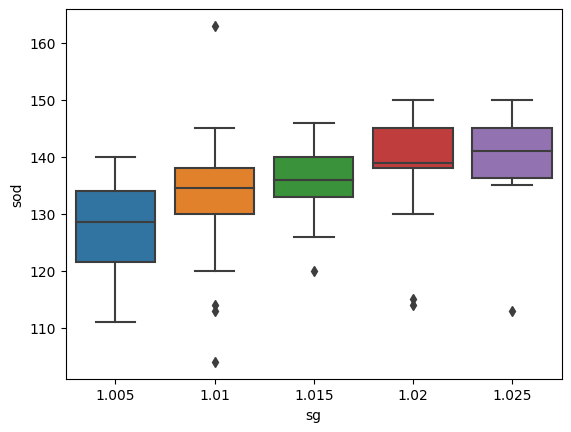

In [ ]:
sns.boxplot(x=user_health_data['sg'], y= user_health_data['sod'])

In [ ]:
median_sod_sg = user_health_data.groupby(by='sg')['sod'].median()

median_sod_sg_dict = median_sod_sg.to_dict()

median_sod_sg_dict

{1.005: 128.5, 1.01: 134.5, 1.015: 136.0, 1.02: 139.0, 1.025: 141.0}

In [ ]:
x = user_health_data.loc[user_health_data['sg'].isnull() & (~(user_health_data['sod'].isnull())), :]
x[['sg', 'sod']]

,sg,sod
7,NaN,130.0
10,NaN,135.0
14,NaN,139.0
19,NaN,141.0
25,NaN,136.0
38,NaN,142.0
40,NaN,127.0
41,NaN,141.0
42,NaN,140.0
52,NaN,144.0


In [ ]:
def find_closest(input_val, median_dict):
  min_dist = 9999999
  for key, value in median_dict.items():
    dist_value = abs(value-input_val)
    if dist_value<min_dist:
      min_dist = dist_value
      probable_sg = key
  return probable_sg

In [ ]:
output_sg = []
for elem in x['sod']:
  output_sg.append(find_closest(elem, median_sod_sg_dict))

In [ ]:
user_health_data.loc[user_health_data['sg'].isnull() & (~(user_health_data['sod'].isnull())), 'sg'] = output_sg

In [ ]:
user_health_data['sg'].fillna(value=1.020, inplace=True)

<ipython-input-54-3d6ca56ce558>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(user_health_data['hemo'])


<Axes: xlabel='hemo', ylabel='Density'>

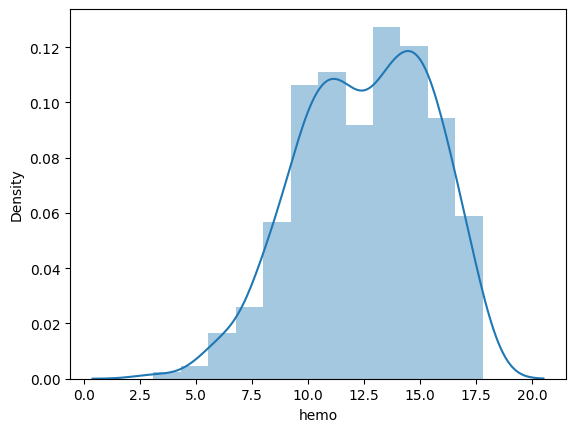

In [ ]:
###### ANALYSIS OF HEMOGLOBIN COLUMN #######

sns.distplot(user_health_data['hemo'])

<Axes: xlabel='hemo', ylabel='rc'>

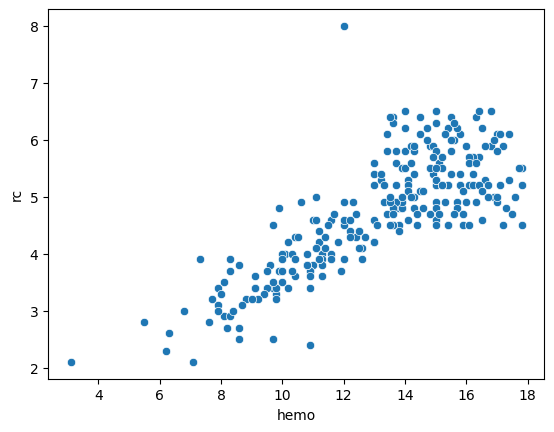

In [ ]:
sns.scatterplot(x=user_health_data['hemo'], y=user_health_data['rc'])

In [ ]:
user_health_data.loc[user_health_data['hemo'].isnull() &(~(user_health_data['rbc'].isnull()))]

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
2,54.0,90.0,1.025,1.0,0.0,normal,abnormal,notpresent,notpresent,150.0,...,NaN,NaN,NaN,no,no,no,poor,yes,yes,ckd
15,24.0,80.0,1.015,2.0,4.0,normal,abnormal,notpresent,notpresent,410.0,...,44.0,6900.0,5.0,no,yes,no,good,yes,no,ckd
44,65.0,60.0,1.010,2.0,0.0,normal,abnormal,present,notpresent,192.0,...,NaN,9500.0,NaN,yes,yes,no,poor,no,no,ckd
52,53.0,100.0,1.010,1.0,3.0,abnormal,normal,notpresent,notpresent,213.0,...,NaN,NaN,NaN,no,yes,no,good,no,no,ckd
72,30.0,60.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,138.0,...,NaN,NaN,NaN,no,no,no,good,no,no,notckd
79,43.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,114.0,...,42.0,NaN,NaN,no,no,no,good,no,no,notckd
89,28.0,70.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,131.0,...,45.0,8600.0,6.5,no,no,no,good,no,no,notckd
92,2.0,80.0,1.010,3.0,0.0,normal,abnormal,notpresent,notpresent,109.0,...,NaN,NaN,NaN,no,no,no,good,yes,no,ckd
102,70.0,70.0,1.010,1.0,0.0,normal,NaN,present,present,171.0,...,NaN,NaN,NaN,no,yes,no,poor,no,no,ckd
122,51.0,100.0,1.015,2.0,0.0,normal,normal,notpresent,present,93.0,...,NaN,NaN,NaN,no,no,no,poor,no,no,ckd


In [ ]:
user_health_data['hemo'].isnull().sum()

54

<Axes: xlabel='htn', ylabel='hemo'>

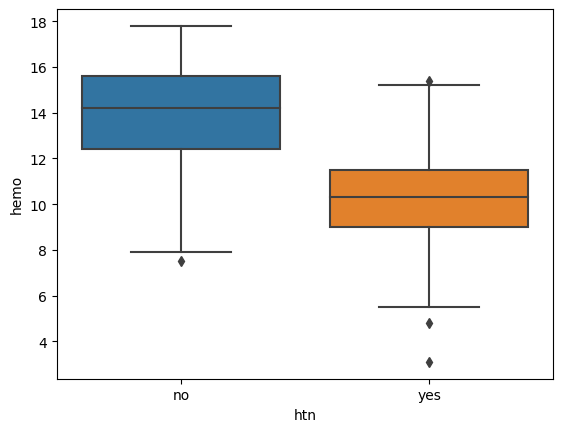

In [ ]:
sns.boxplot(x=user_health_data['htn'], y= user_health_data['hemo'])

In [ ]:
print(user_health_data.loc[user_health_data['htn']=='no', 'hemo'].median())
print(user_health_data.loc[user_health_data['htn']=='yes', 'hemo'].median())

14.2
10.3


In [ ]:
user_health_data.loc[(user_health_data['hemo'].isnull()) & (user_health_data['htn']=='no'), 'hemo'] = 14.2
user_health_data.loc[(user_health_data['hemo'].isnull()) & (user_health_data['htn']=='yes'), 'hemo'] = 10.3

In [ ]:
######### ANALYSIS OF SU Column #######

user_health_data['su'].fillna(value=0, inplace=True)

In [ ]:
######## DROP COLUMNS WHERE MISSING PERCENTAGE IS GREATER THAN 0 (NOT PERMANANT) ########

user_health_data.dropna(axis=1, inplace=True)

In [ ]:
user_health_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             400 non-null    float64
 1   bp              400 non-null    float64
 2   sg              400 non-null    float64
 3   al              400 non-null    float64
 4   su              400 non-null    float64
 5   pcc             400 non-null    object 
 6   ba              400 non-null    object 
 7   bgr             400 non-null    float64
 8   bu              400 non-null    float64
 9   sc              400 non-null    float64
 10  hemo            400 non-null    float64
 11  htn             400 non-null    object 
 12  dm              400 non-null    object 
 13  cad             400 non-null    object 
 14  appet           400 non-null    object 
 15  pe              400 non-null    object 
 16  ane             400 non-null    object 
 17  classification  400 non-null    obj

In [ ]:
obj_cols = user_health_data.select_dtypes('object')
obj_cols.drop('classification', axis=1, inplace=True)

obj_column_names = obj_cols.columns

In [ ]:
obj_cols

,pcc,ba,htn,dm,cad,appet,pe,ane
0,notpresent,notpresent,no,no,no,good,no,no
1,notpresent,notpresent,no,no,no,good,no,no
2,notpresent,notpresent,no,no,no,good,no,no
3,notpresent,notpresent,yes,yes,no,good,no,no
4,notpresent,notpresent,no,no,no,good,no,no
...,...,...,...,...,...,...,...,...
395,notpresent,notpresent,no,no,no,good,yes,no
396,notpresent,notpresent,no,no,no,good,no,no
397,notpresent,notpresent,no,no,no,good,no,no
398,notpresent,notpresent,no,no,no,good,no,no


In [ ]:
obj_column_names

Index(['pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane'], dtype='object')

In [ ]:
############ CONVERTING TO DUMMY COLUMNS #########
ohe = OneHotEncoder()

ohe.fit(obj_cols) ### Look at every column and identify the unique values in the columns

new_cols = ohe.get_feature_names_out(obj_column_names)

transformed_cols = ohe.transform(obj_cols).toarray() ## create the dummy columns

transformed_cols = pd.DataFrame(transformed_cols, columns=new_cols)

user_health_data.drop(obj_column_names, axis=1, inplace=True)

user_health_data = pd.concat([user_health_data, transformed_cols], axis=1)

#user_health_data[list(obj_column_names)] = ohe.transform(obj_cols)

In [ ]:
user_health_data

,age,bp,sg,al,su,bgr,bu,sc,hemo,classification,...,dm_no,dm_yes,cad_no,cad_yes,appet_good,appet_poor,pe_no,pe_yes,ane_no,ane_yes
0,55.0,80.0,1.020,0.0,0.0,118.0,18.0,0.9,15.5,0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,20.0,60.0,1.025,0.0,0.0,109.0,37.0,1.0,14.0,0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,50.0,80.0,1.020,0.0,0.0,97.0,40.0,0.6,14.2,0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,66.0,70.0,1.015,2.0,5.0,447.0,41.0,1.7,12.5,1,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,64.0,60.0,1.020,0.0,0.0,106.0,27.0,0.7,14.4,0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,50.0,90.0,1.015,1.0,0.0,109.0,67.0,3.0,14.2,1,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
396,36.0,80.0,1.025,0.0,0.0,85.0,16.0,1.1,15.6,0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
397,51.0,60.0,1.020,0.0,0.0,129.0,25.0,1.2,17.2,0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
398,19.0,80.0,1.020,0.0,0.0,107.0,23.0,0.7,14.4,0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [ ]:
user_health_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             400 non-null    float64
 1   bp              400 non-null    float64
 2   sg              400 non-null    float64
 3   al              400 non-null    float64
 4   su              400 non-null    float64
 5   bgr             400 non-null    float64
 6   bu              400 non-null    float64
 7   sc              400 non-null    float64
 8   hemo            400 non-null    float64
 9   classification  400 non-null    int64  
 10  pcc_notpresent  400 non-null    float64
 11  pcc_present     400 non-null    float64
 12  ba_notpresent   400 non-null    float64
 13  ba_present      400 non-null    float64
 14  htn_no          400 non-null    float64
 15  htn_yes         400 non-null    float64
 16  dm_no           400 non-null    float64
 17  dm_yes          400 non-null    flo

In [ ]:
numeric_classification = []

for elem in user_health_data['classification']:
  if elem == 'ckd':
    numeric_classification.append(1)
  else:
    numeric_classification.append(0)

user_health_data['classification'] = numeric_classification

In [ ]:
############# Creating training features and targets #########

train_features = user_health_data.drop('classification', axis=1)
train_targets = user_health_data['classification']

In [ ]:
######### LETS START MODELLING ###########

######## DECISION TREES USING GRID SEARCH CV ########

params_dict = {
    "max_depth": [3,4,5],
    "criterion": ['gini'],
    "min_samples_split": [5,10,15, 20],
    "class_weight": [{1: 1, 0: 1}, 'balanced', {1:0.8, 0: 1.2}, {1:1, 0:2}]
}

clf = DecisionTreeClassifier()

grid_search = GridSearchCV(estimator = clf,
                           param_grid = params_dict,
                           cv = 5,
                           scoring = 'f1',
                           return_train_score=True) #### cv- 5 (5 fold cross validation)


grid_search.fit(train_features, train_targets)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': [{0: 1, 1: 1}, 'balanced',
                                          {0: 1.2, 1: 0.8}, {0: 2, 1: 1}],
                         'criterion': ['gini'], 'max_depth': [3, 4, 5],
                         'min_samples_split': [5, 10, 15, 20]},
             return_train_score=True, scoring='f1')

In [ ]:
####### Analyze the results #######

results = pd.DataFrame({'Params': grid_search.cv_results_['params'],
                        'TrainF1': grid_search.cv_results_['mean_train_score'],
                        'ValF1': grid_search.cv_results_['mean_test_score']})

results.to_csv('DecisionTreeResults.csv', index=None)

In [ ]:
###### FIT THE MODEL WITH BEST Combinations #####

clf = DecisionTreeClassifier(class_weight={1: 1, 0: 1},
                             criterion='gini',
                             max_depth=4,
                             min_samples_split=10)

clf.fit(train_features, train_targets)

with open('decisiontreemodel.pickle', 'wb') as f:
  pickle.dump(clf, f)

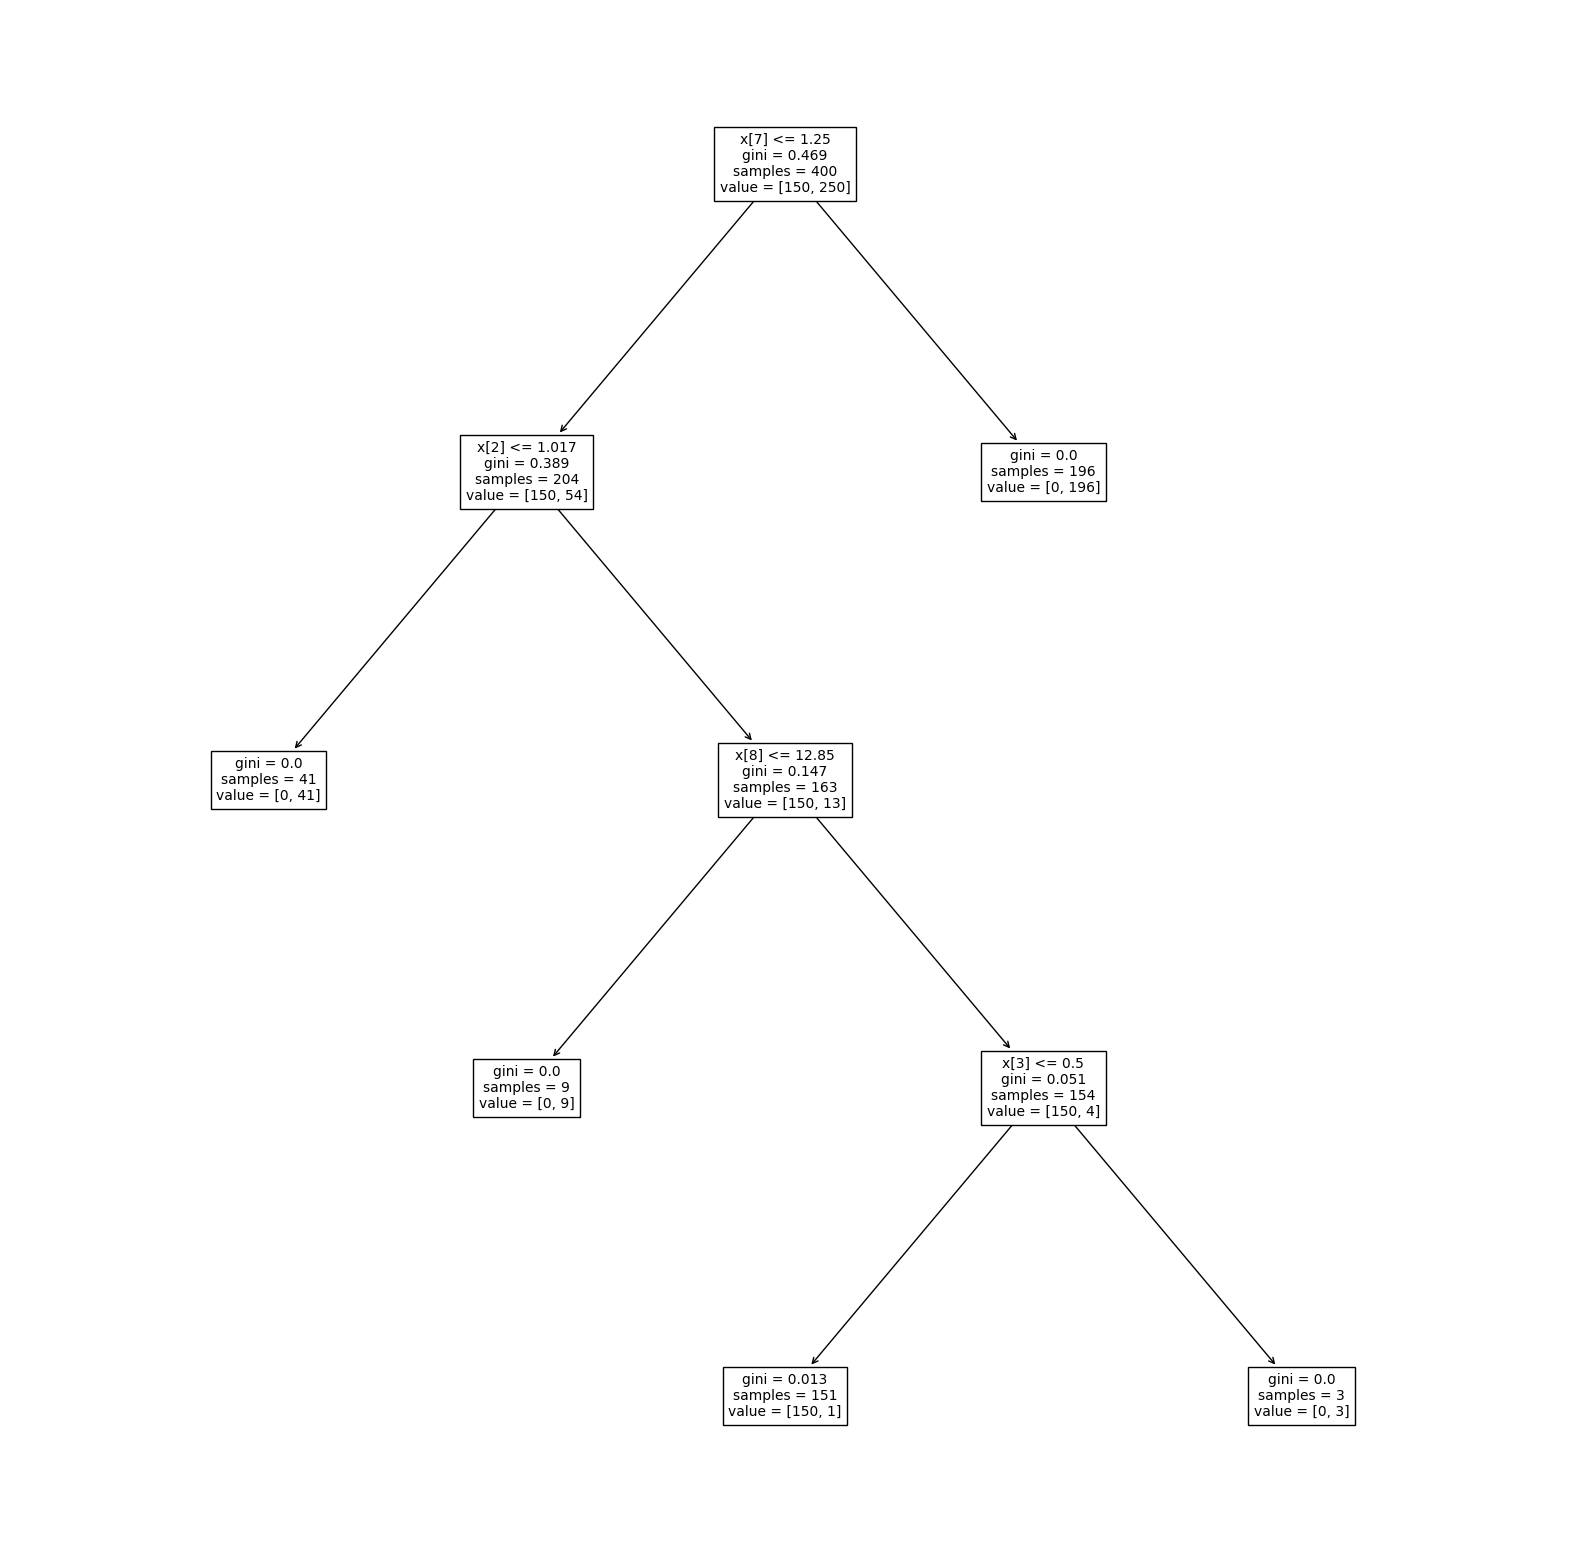

In [ ]:
from sklearn.tree import plot_tree
plot_rows =1
plot_cols = 1

fig, ax1 = plt.subplots(nrows = plot_rows,ncols=plot_cols,figsize = (20,20))

plot_tree(clf, ax=ax1, fontsize=10)
plt.show()

In [ ]:
dict(zip(train_features.columns,list(clf.feature_importances_)))

{'age': 0.0,
 'bp': 0.0,
 'sg': 0.29909122838038066,
 'al': 0.03129400719762167,
 'su': 0.0,
 'bgr': 0.0,
 'bu': 0.0,
 'sc': 0.5826443027010001,
 'hemo': 0.08697046172099757,
 'pcc_notpresent': 0.0,
 'pcc_present': 0.0,
 'ba_notpresent': 0.0,
 'ba_present': 0.0,
 'htn_no': 0.0,
 'htn_yes': 0.0,
 'dm_no': 0.0,
 'dm_yes': 0.0,
 'cad_no': 0.0,
 'cad_yes': 0.0,
 'appet_good': 0.0,
 'appet_poor': 0.0,
 'pe_no': 0.0,
 'pe_yes': 0.0,
 'ane_no': 0.0,
 'ane_yes': 0.0}

<Axes: xlabel='classification', ylabel='sc'>

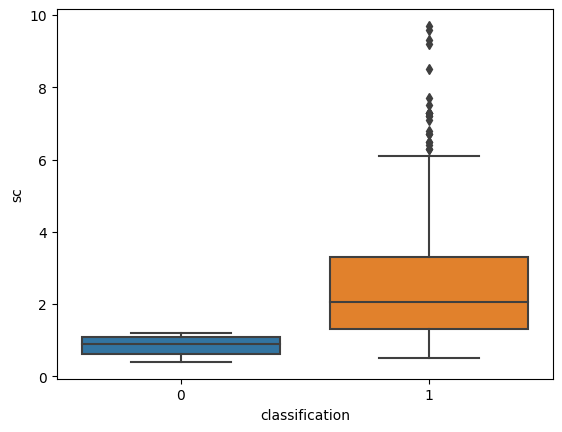

In [ ]:
sns.boxplot(x=user_health_data.loc[user_health_data['sc']<=10, 'classification'],
            y=user_health_data.loc[user_health_data['sc']<=10, 'sc'])

In [ ]:
########## ENSEMBLE MODEL ########

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

lr_model =  LogisticRegression(max_iter=500)
svm_model = SVC()
knn_model = KNeighborsClassifier()
rf_model = RandomForestClassifier()
dt_model = DecisionTreeClassifier()

ensemble_model= VotingClassifier([('lr', lr_model),
                                  ('svm', svm_model),
                                  ('knn', knn_model),
                                  ('rf', rf_model),
                                  ('dt', dt_model)], voting='hard')

ensemble_model.fit(train_features, train_targets)

VotingClassifier(estimators=[('lr', LogisticRegression(max_iter=500)),
                             ('svm', SVC()), ('knn', KNeighborsClassifier()),
                             ('rf', RandomForestClassifier()),
                             ('dt', DecisionTreeClassifier())])

In [ ]:
from sklearn.metrics import confusion_matrix
prediction = ensemble_model.predict(train_features)
actuals = train_targets.tolist()

confusion_matrix(actuals, prediction)

array([[150,   0],
       [  4, 246]])